# Ensemble Volatility

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [8]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [9]:
import random

# Choose a random stock
stock_symbol = random.choice(stock_list.iloc[:,0])
print(stock_symbol)

COP


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [10]:
# Environment variables
from dotenv import load_dotenv
load_dotenv("../mysql.env")

import os
import sys
import mysql.connector

HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [11]:
df = histdailyprice3.copy()

In [12]:
df.head()

,Date,Close,Open,High,Low,Volume
0,1998-01-01,24.31,24.31,24.31,24.31,0
1,1998-01-02,24.25,24.35,23.75,24.00,536200
2,1998-01-05,23.97,24.22,23.50,23.56,2063800
3,1998-01-06,23.13,23.13,22.44,22.60,1852600
4,1998-01-07,22.53,22.75,22.28,22.75,3203600


In [13]:
returns = 100 * df['Close'].pct_change().dropna()
realized_vol = returns.rolling(5).std()

In [14]:
n = int(len(returns)*0.4)
split_date = returns[-n:].index

# ARCH

In [15]:
from arch import arch_model
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -14964.0
Distribution:                  Normal   AIC:                           29931.9
Method:            Maximum Likelihood   BIC:                           29945.4
                                        No. Observations:                 6176
Date:                Wed, Jan 05 2022   Df Residuals:                     6176
Time:                        21:25:37   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          7.1299      2.683      2.657  7.880e-03    [  

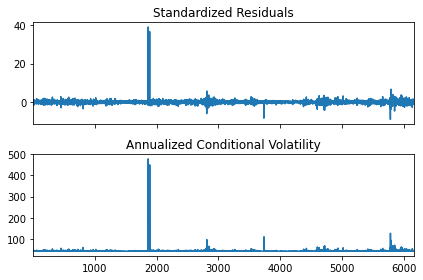

In [16]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

In [17]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=1)

In [18]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
         best_param = p
arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -13788.5
Distribution:                  Normal   AIC:                           27584.9
Method:            Maximum Likelihood   BIC:                           27611.8
                                        No. Observations:                 6176
Date:                Wed, Jan 05 2022   Df Residuals:                     6176
Time:                        21:25:39   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          2.1388      0.198     10.798  3.502e-27    

In [19]:
from sklearn.metrics import mean_squared_error as mse

forecast_arch.variance

,h.1
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
6172,2.467806
6173,6.523055
6174,6.481633
6175,2.440091


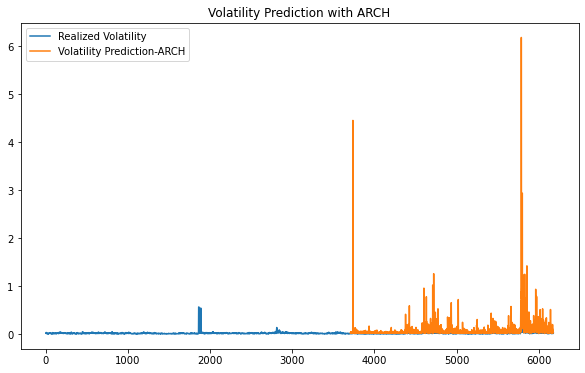

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [21]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.2499


# GARCH

In [22]:
garch = arch_model(returns, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14129.1
Distribution:                  Normal   AIC:                           28264.2
Method:            Maximum Likelihood   BIC:                           28284.4
                                        No. Observations:                 6176
Date:                Wed, Jan 05 2022   Df Residuals:                     6176
Time:                        21:25:43   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4081      0.311      1.312      0.190    [ -

In [23]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13502.3
Distribution:                  Normal   AIC:                           27018.6
Method:            Maximum Likelihood   BIC:                           27065.7
                                        No. Observations:                 6176
Date:                Wed, Jan 05 2022   Df Residuals:                     6176
Time:                        21:25:46   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.6393      0.222      2.878  4.006e-03    

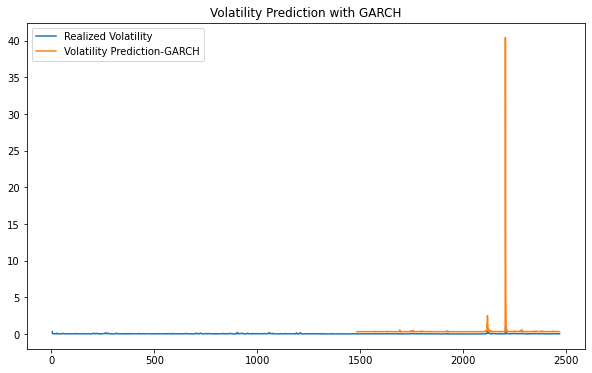

In [18]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

In [19]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.5854


# GJR GARCH

In [20]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(returns, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
             best_param = p, q
gjrgarch = arch_model(returns, mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

bic_garch = []

/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7286.91
Distribution:                  Normal   AIC:                           14591.8
Method:            Maximum Likelihood   BIC:                           14644.1
                                        No. Observations:                 2467
Date:                Wed, Jan 05 2022   Df Residuals:                     2467
Time:                        13:29:29   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0865      0.293      0.295      0.768 

/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


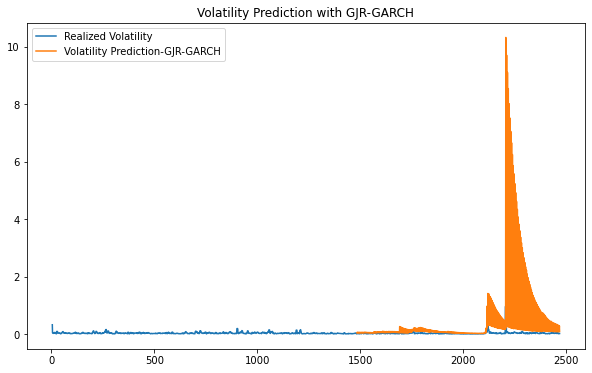

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

In [22]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.5136


# EGARCH

In [23]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
    egarch = arch_model(returns, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1]).fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

/Users/simplypatrickg/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -7706.49
Distribution:                  Normal   AIC:                           15431.0
Method:            Maximum Likelihood   BIC:                           15483.3
                                        No. Observations:                 2467
Date:                Wed, Jan 05 2022   Df Residuals:                     2467
Time:                        13:29:30   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8098      0.708      2.557  1.056e-02 [  0.423,  3.19

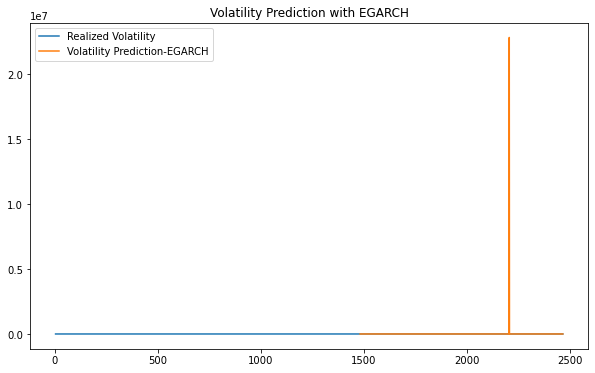

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [25]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 152.1178


# SVR GARCH

In [14]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [15]:
realized_vol = returns.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = returns ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['index']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

## Linear

In [28]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns.iloc[-n:].index

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.083415


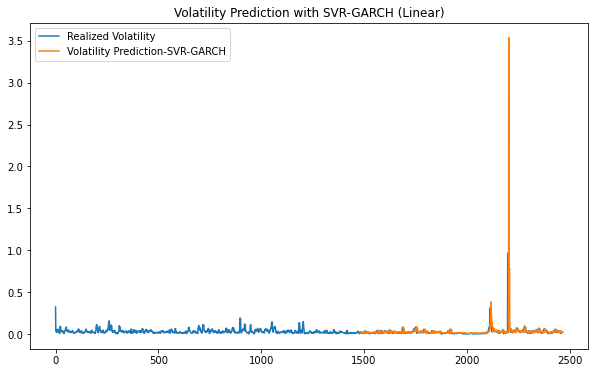

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [30]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.083415


## Radial basis function

In [31]:
para_grid ={'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = returns.iloc[-n:].index

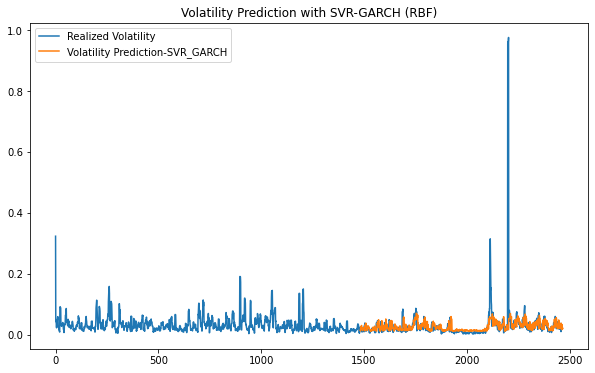

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

In [33]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.067333


## Polynomial Kernal

In [ ]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = returns.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)', fontsize=12)
plt.legend()
plt.show()

In [ ]:
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))

# Neural Networks

In [ ]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [500, 1000],
                'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = returns.iloc[-n:].index

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

In [ ]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

## TensorFlow

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse

In [19]:
model = keras.Sequential([layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='rmsprop')
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

DL_RMSE_1:0.027809
DL_RMSE_2:0.071682
DL_RMSE_3:0.130523
DL_RMSE_4:0.279138


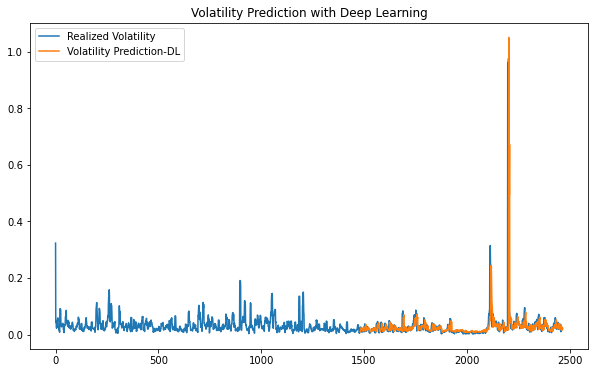

In [23]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = returns.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

# Bayesian Approach

In [4]:
#!pip install git+https://github.com/RJT1990/pyflux
import pyflux as pf
from scipy.stats import kurtosis

Acceptance rate of Metropolis-Hastings is 0.1415
Acceptance rate of Metropolis-Hastings is 0.2204
Acceptance rate of Metropolis-Hastings is 0.3111

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.31135


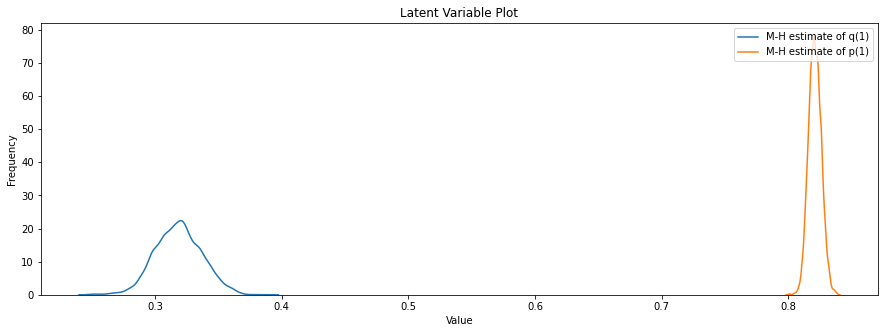

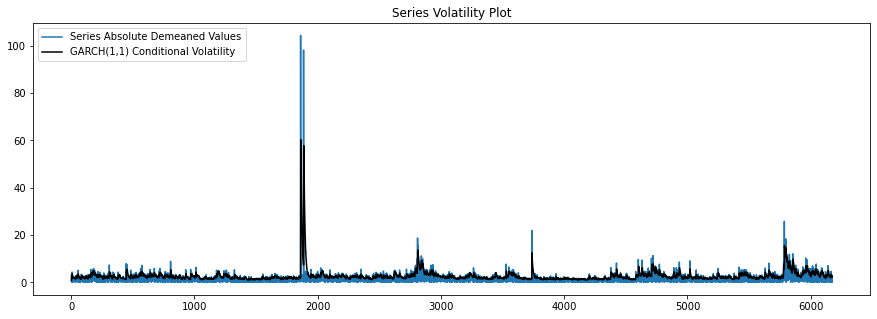

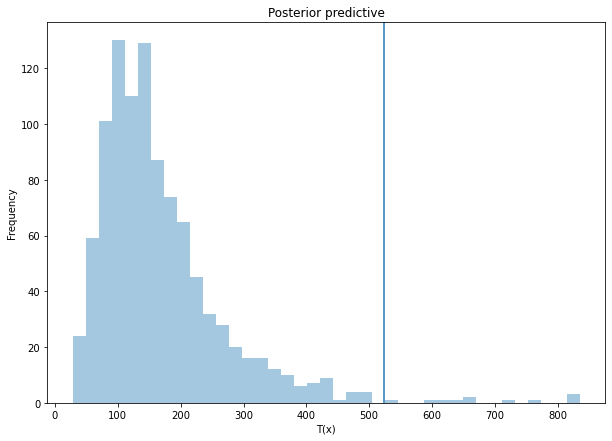

In [24]:
model = pf.GARCH(returns.values, p=1, q=1)
print(model.latent_variables)
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x = model.fit(method='M-H', iterations='1000')
print(x.summary())

model.plot_z([1, 2])
model.plot_fit(figsize=(15, 5))
model.plot_ppc(T=kurtosis, nsims=1000)

In [ ]:
bayesian_prediction = model.predict_is(n, fit_method='M-H')
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100, bayesian_prediction.values / 100))
bayesian_prediction.index = returns.iloc[-n:].index

Acceptance rate of Metropolis-Hastings is 0.15535
Acceptance rate of Metropolis-Hastings is 0.23775

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.242575


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100, label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()

# RSME

In [24]:
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))
print('The RMSE value of DL_RMSE is'.format(DL_RMSE))


NameError: name 'rmse_arch' is not defined